# AGNFinder CVAE Framework Test (1)

**Author:** Maxime Robeyns (2021) <maximerobeyns@gmail.com>

In this notebook, we perform conditional handwritten digit generation to test the CVAE implementation in the AGNFinder codebase. We use the MNIST dataset for training.

In [1]:
import os
import numpy as np
import torch as t
import torch.nn as nn

from typing import Union
from IPython import display
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import agnfinder.inference.distributions as dist

from agnfinder import config as cfg
from agnfinder.types import DistParams, arch_t
from agnfinder.inference.utils import _load_mnist, _onehot
from agnfinder.inference.base import CVAE, CVAEPrior, CVAEEnc, CVAEDec, \
                                      CVAEParams, _CVAE_Dist, _CVAE_RDist

In [ ]:
try: # One-time setup
    assert(_SETUP)
except NameError:
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning)  # see torchvision pr #4184
    cfg.configure_logging()
    # %matplotlib inline
    while not '.git' in os.listdir():
        os.chdir("../")
    dtype = t.float64
    device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
    if device == t.device("cuda"):
        !nvidia-smi
    else:
        print('CUDA is unavailable; training on CPU.')
    _SETUP = True

## CVAE Setup

Recall that our training objective, the ELBO, can be expressed as follows:

\begin{align*}
    \mathcal{L}_{\text{CVAE}}(\theta, \phi; x, y) &= 
    \mathbb{E}_{q_{\phi}(z \vert y, x)}\left[\log p_{\theta}(y \vert z, x)\right]
     - D_{\text{KL}}\left[q_{\phi}(z \vert y, x) \Vert p_{\theta}(z \vert x)\right] \\
       &= \mathbb{E}_{q_{\phi}(z \vert y, x)}\big[\log p_{\theta}(y \vert z, x) + \log p_{\theta}(z \vert x) - \log q_{\phi}(z \vert y, x)\big] \\
       &\doteq \mathbb{E}\big[\mathcal{L}_{\text{logpy}} +
       \mathcal{L}_{\text{logpz}} - \mathcal{L}_{\text{logqz}} \big].
\end{align*}

Here we will select a standard Gaussian prior $p_{\theta}(z \vert x) = \mathcal{N}(z; 0, \mathbf{I})$ (that is, we do not condition this distribution on $x$), which we implement by extending the `CVAEPrior` class, and using the factorised Gaussian distribution made available in `agnfinder.inference.distributions`.

For the encoder network $q_{\phi}(z \vert y, x)$, we also select a factorised Gaussian. This time, when we extend the `CVAEEnc` class, we must return a reparametrised distribution from the `get_dist` method (i.e. a `_CVAE_RDist`). Once again, we use one of the distributions in `agnfinder.inference.distributions`.

The decoder $p_{\theta}(y \vert z, x)$ is also Gaussian; it needn't use reparametrised sampling—indeed, we never sample from it in the CVAE training procedure, however even if we did it wouldn't be beneficial nor detrimental.

In [3]:
class StandardGaussianPrior(CVAEPrior):
    def get_dist(self, _) -> _CVAE_Dist:
        mean = t.zeros(self.latent_dim, device=self.device, dtype=self.dtype)
        std = t.ones(self.latent_dim, device=self.device, dtype=self.dtype)
        return dist.Gaussian(mean, std)


class GaussianEncoder(CVAEEnc):
    def get_dist(self, dist_params: Union[t.Tensor, DistParams]) -> _CVAE_RDist:
        assert isinstance(dist_params, list)
        mean = dist_params[0]
        std = t.exp(dist_params[1])  # network outputs log_std as 2nd param
        return dist.R_Gaussian(mean, std)
    

class GaussianDecoder(CVAEDec):
    def get_dist(self, dist_params: Union[t.Tensor, DistParams]) -> _CVAE_Dist:
        assert isinstance(dist_params, list) and len(dist_params) == 2
        [mean, log_std] = dist_params
        std = t.exp(log_std)
        return dist.Gaussian(mean, std)

We now parametrise the CVAE instance. The `cond_dim` is 10, since we may choose to condition on digits $x \in \{0, \ldots, 9\}$, and we one-hot encode these. The `data_dim` is $784 = 28\times 28$ to reflect the size of a flattened MNIST image. 

The `latent_dim` is arbitrarily chosen; make this too large and the representations we learn will suffer, since the VAE has little incentive to compress an input image efficiently in order to acheive a good reconstruction. Make this too small, and the network may struggle to retain enough information in the latent code to reconstruct the input again effectively (although this is unlikely for this toy MNIST example, even at $\mathtt{latent\_dim} = 1$).

Since the `StandardGaussianPrior` doesn't use the conditioning information $x$ provided to it, we use a `prior_arch = None` to avoid instantiating an unnecessary network.

For the encoder and decoder, the number of output 'heads' matches the number of parameters that the corresponding distribution is expecting. For the decoder, we use a sigmoid activation on the mean since the MNIST pixel data lies in $y \in [0, 1]^{28\times 28}$.

In [4]:
class MNIST_img_params(CVAEParams):
    cond_dim = 10  # x; dimension of one-hot labels
    data_dim = 28*28  # y; size of MNIST image
    latent_dim = 2  # z

    prior = StandardGaussianPrior
    prior_arch = None

    encoder = GaussianEncoder
    enc_arch = arch_t([data_dim + cond_dim, 256], [latent_dim, latent_dim],
                      nn.ReLU(), batch_norm=False)

    decoder = GaussianDecoder
    dec_arch = arch_t([latent_dim + cond_dim, 256], [data_dim, data_dim],
                      nn.ReLU(), [nn.Sigmoid(), nn.ReLU()], batch_norm=False)

This class is called at every logging iteration, and just visualises the current state of the decoder network by conditioning on digits $x = \{0, \ldots, 9\}$ and plotting the mean.

In [46]:
class LogVisual():
    def __init__(self, figure, display):
        self.fig = figure
        self.disp = display
        self.ax = figure.subplots(1, 10)
        for i in range(10):
            self.ax[i].axis('off')
            self.ax[i].set_title(f'x={i}', fontsize=15)

    def __call__(self, cvae: CVAE):
        with t.no_grad():
            x = t.eye(10, device=cvae.device, dtype=cvae.dtype)
            z = cvae.prior.get_dist(None).sample((10,))
            ys, _ = cvae.decoder.forward(t.cat((z, x), -1))
            for i in range(10):
                self.ax[i].imshow(-ys[i].view(28, 28).cpu().data.numpy(), 
                                  cmap=plt.get_cmap('PuBu'))
            self.fig.tight_layout()
            self.disp.update(self.fig)

Here we minimally modify the base CVAE class by overriding the base `preprocess` method to work with the MNIST data.

Since MNIST is usually used for classification tasks, the data coming out of  the data loader will have $x$ as the pixel data, and $y$ as the corresponding integer MNIST labels.

However, here we want $x$ to be one-hot encoded labels, and $y$ to be the flattened pixel data; so we apply the necessary transformations in this function, and switch the order of the two before returning.

In [47]:
class MNIST_img_cvae(CVAE):

    def preprocess(self, x: t.Tensor, y: t.Tensor) -> tuple[t.Tensor, t.Tensor]:
        if x.dim() > 2:
            x = x.view(-1, 28*28)
        switched_x = _onehot(y, 10).to(self.device, self.dtype)
        switched_y = x.to(self.device, self.dtype)
        return switched_x, switched_y
    
    # trainmodel and ELBO methods kept as in base class

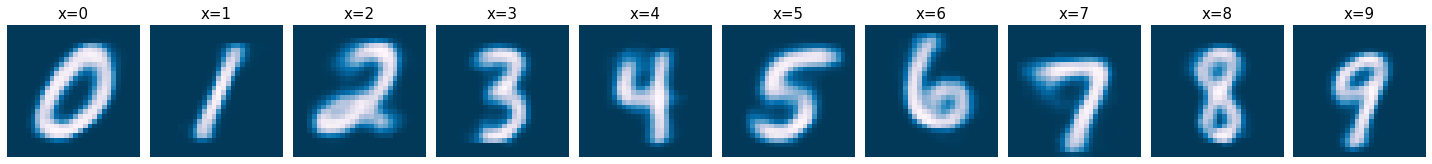

2021-08-27 10:39:12,742 [INFO] Epoch: 00/05, Batch: 000/937, Loss  846.5312
2021-08-27 10:39:13,827 [INFO] Epoch: 00/05, Batch: 100/937, Loss  744.6399
2021-08-27 10:39:15,061 [INFO] Epoch: 00/05, Batch: 200/937, Loss  742.2092
2021-08-27 10:39:16,270 [INFO] Epoch: 00/05, Batch: 300/937, Loss  740.1060
2021-08-27 10:39:17,381 [INFO] Epoch: 00/05, Batch: 400/937, Loss  739.3348
2021-08-27 10:39:18,521 [INFO] Epoch: 00/05, Batch: 500/937, Loss  738.8299
2021-08-27 10:39:19,738 [INFO] Epoch: 00/05, Batch: 600/937, Loss  740.6019
2021-08-27 10:39:20,950 [INFO] Epoch: 00/05, Batch: 700/937, Loss  739.5086
2021-08-27 10:39:22,190 [INFO] Epoch: 00/05, Batch: 800/937, Loss  740.1409
2021-08-27 10:39:23,458 [INFO] Epoch: 00/05, Batch: 900/937, Loss  738.3460
2021-08-27 10:39:24,198 [INFO] Epoch: 00/05, Batch: 937/937, Loss  739.4543
2021-08-27 10:39:24,852 [INFO] Epoch: 01/05, Batch: 000/937, Loss  738.7666
2021-08-27 10:39:26,206 [INFO] Epoch: 01/05, Batch: 100/937, Loss  738.7147
2021-08-27 1

In [48]:
fig = plt.figure(figsize=(20, 2.5))
disp = display.display("", display_id=True)

cvae = MNIST_img_cvae(MNIST_img_params(), device=device, dtype=dtype, 
                      logging_callbacks=[LogVisual(fig, disp)])
train_loader, _ = _load_mnist()

cvae.trainmodel(train_loader, epochs=5)
plt.close()